# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [71]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [72]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [73]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [74]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-05-05 20:10:49.790755
metric: deaths at 2020-05-05 20:10:51.042357
Latest data from 2020-05-05


In [75]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [76]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-05              US    1204351          23976   71064        2142   
1  2020-05-05  United Kingdom     196243           4411   29501         692   
2  2020-05-05           Italy     213013           1075   29315         236   
3  2020-05-05           Spain     219329           1318   25613         185   
4  2020-05-05          France     170687           1104   25537         333   
5  2020-05-05         Belgium      50509            242    8016          92   
6  2020-05-05          Brazil     115455           6835    7938         571   
7  2020-05-05         Germany     167007            855    6993           0   
8  2020-05-05            Iran      99970           1323    6340          63   
9  2020-05-05     Netherlands      41286            318    5185          87   
10 2020-05-05           China      83968              2    4637           0   
11 2020-05-05          Canada      63215           1258    4190         187   
12 2020-05-05          Turkey     129491           1832    3520          59   
13 2020-05-05          Sweden      23216            495    2854          85   
14 2020-05-05          Mexico      26025           1120    2507         236   
15 2020-05-05     Switzerland      30009             28    1795          11   
16 2020-05-05           India      49400           2963    1693         127   
17 2020-05-05         Ecuador      31881              0    1569           0   
18 2020-05-05          Russia     155370          10102    1451          95   
19 2020-05-05            Peru      51189           3817    1444         100   

    mortality_rate  
0         0.059006  
1         0.150329  
2         0.137621  
3         0.116779  
4         0.149613  
5         0.158704  
6         0.068754  
7         0.041872  
8         0.063419  
9         0.125587  
10        0.055223  
11        0.066282  
12        0.027183  
13        0.122932  
14        0.096330  
15        0.059815  
16        0.034271  
17        0.049214  
18        0.009339  
19        0.028209

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [77]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-05              US    1204351          23976   71064        2142   
18 2020-05-05          Russia     155370          10102    1451          95   
6  2020-05-05          Brazil     115455           6835    7938         571   
1  2020-05-05  United Kingdom     196243           4411   29501         692   
19 2020-05-05            Peru      51189           3817    1444         100   
16 2020-05-05           India      49400           2963    1693         127   
12 2020-05-05          Turkey     129491           1832    3520          59   
44 2020-05-05    Saudi Arabia      30251           1595     200           9   
36 2020-05-05           Chile      22016           1373     275           5   
8  2020-05-05            Iran      99970           1323    6340          63   

    mortality_rate  
0         0.059006  
18        0.009339  
6         0.068754  
1         0.150329  
19        0.028209  
16        0.034271  
12        0.027183  
44        0.006611  
36        0.012491  
8         0.063419

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [78]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

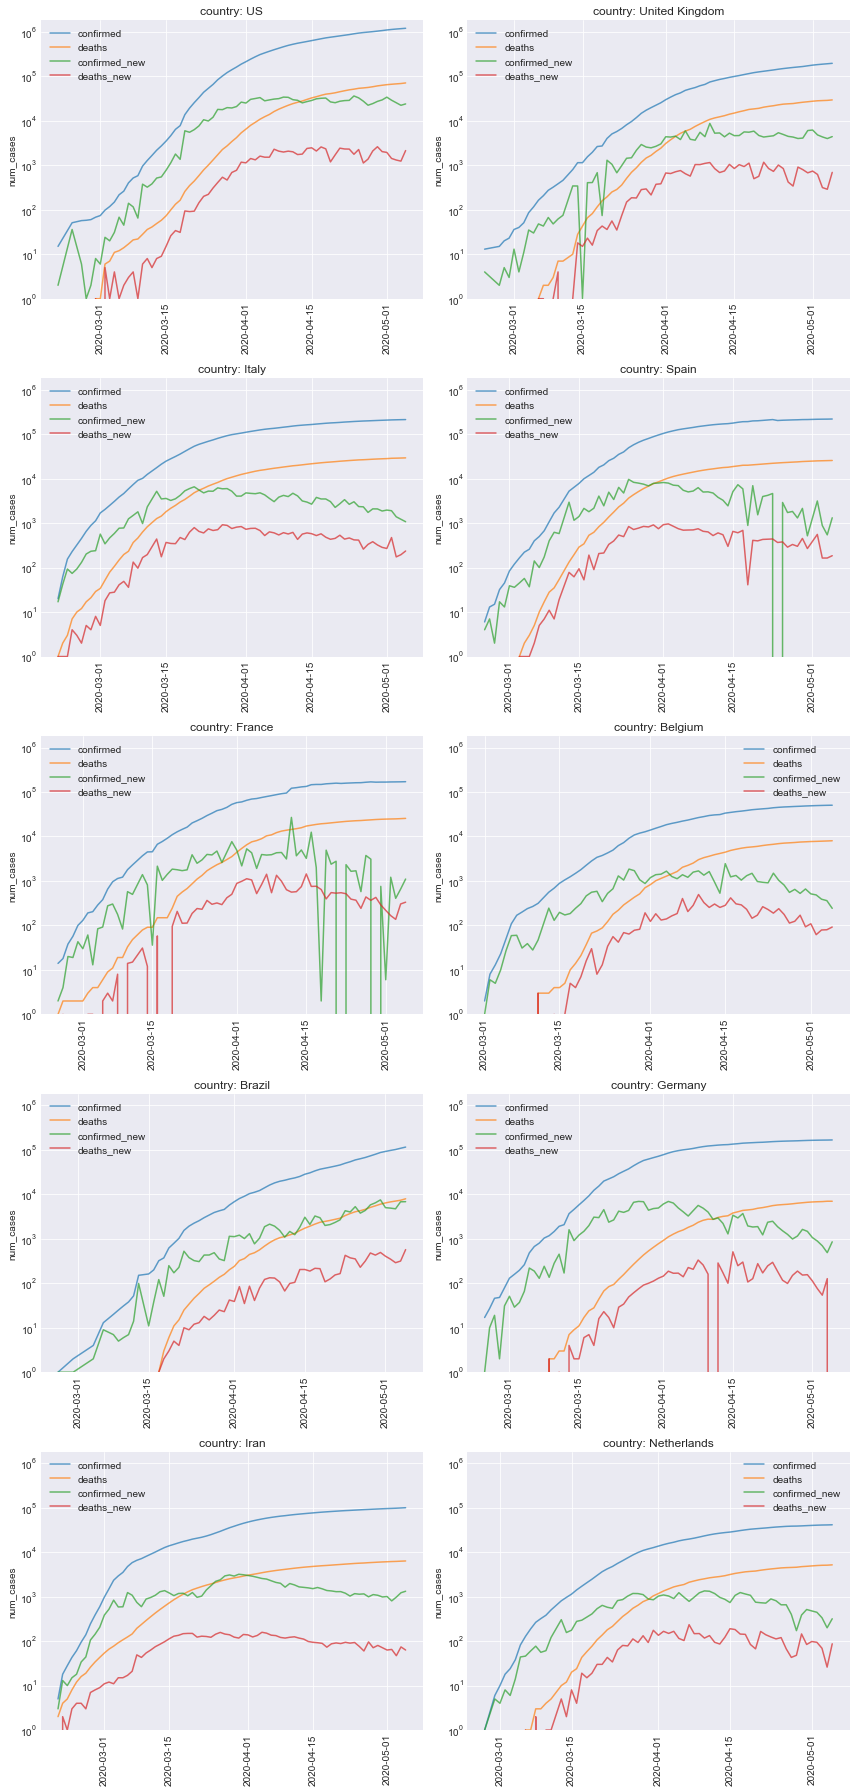

In [79]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

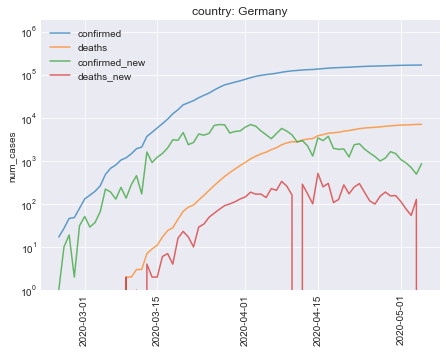

In [80]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [81]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-06 2020-05-12 2020-05-26  2020-05-06 2020-05-12   
country                                                                      
US                  1241420.0  1438042.0  2026570.0     72803.0    84239.0   
United Kingdom       202961.0   238694.0   348478.0     30142.0    33802.0   
Italy                215223.0   225298.0   250681.0     29681.0    31467.0   
Spain                220549.0   227760.0   245517.0     25909.0    27398.0   
France               171082.0   175181.0   185131.0     25692.0    27128.0   
Brazil               122506.0   174514.0   398477.0      8388.0    11812.0   
Belgium               51160.0    53977.0    61168.0      8104.0     8647.0   
Germany              168131.0   173537.0   186837.0      7142.0     7719.0   
Iran                 100799.0   107423.0   124624.0      6405.0     6810.0   
Netherlands           41812.0    44233.0    50443.0      5281.0     5786.0   

                          mortality_rate_pred                        \
date           2020-05-26          2020-05-06 2020-05-12 2020-05-26   
country                                                               
US               118403.0            0.058645   0.058579   0.058425   
United Kingdom    44163.0            0.148511   0.141612   0.126731   
Italy             36062.0            0.137908   0.139668   0.143856   
Spain             31214.0            0.117475   0.120293   0.127136   
France            30798.0            0.150174   0.154857   0.166358   
Brazil            26251.0            0.068470   0.067685   0.065878   
Belgium           10058.0            0.158405   0.160198   0.164432   
Germany            9252.0            0.042479   0.044480   0.049519   
Iran               7857.0            0.063542   0.063394   0.063046   
Netherlands        7160.0            0.126303   0.130807   0.141942   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.024807             0.024615  
United Kingdom                0.027396             0.019281  
Italy                         0.007654             0.009784  
Spain                         0.005377             0.009356  
France                        0.003954             0.009105  
Brazil                        0.060748             0.058700  
Belgium                       0.008973             0.010859  
Germany                       0.005289             0.013028  
Iran                          0.010665             0.010271  
Netherlands                   0.009427             0.015330

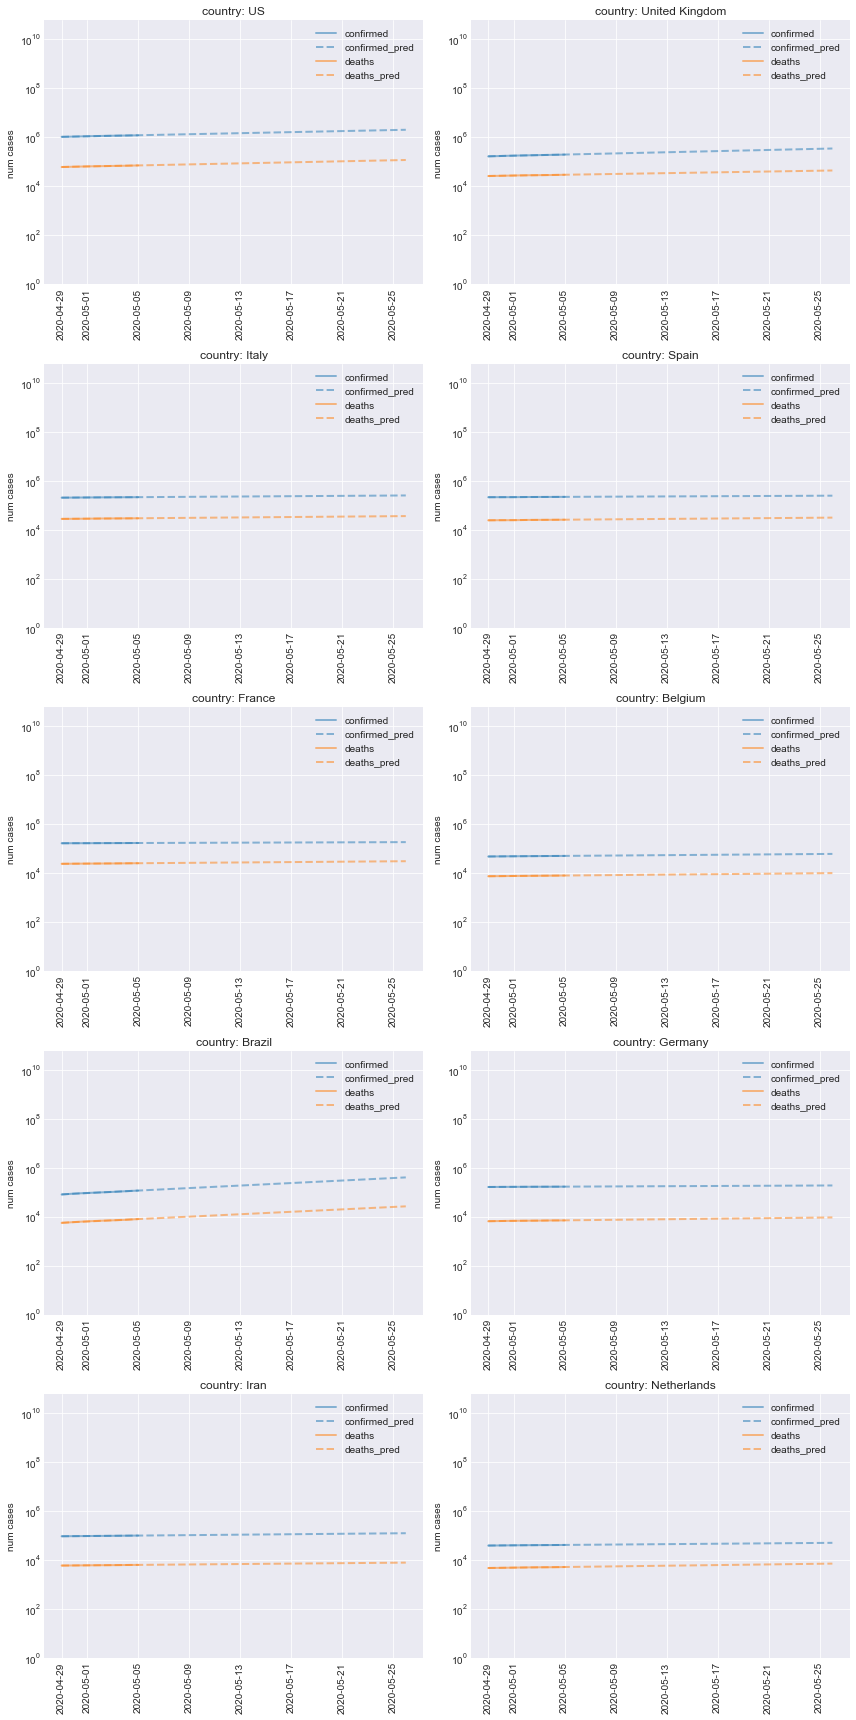

In [82]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [83]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-05_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [84]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


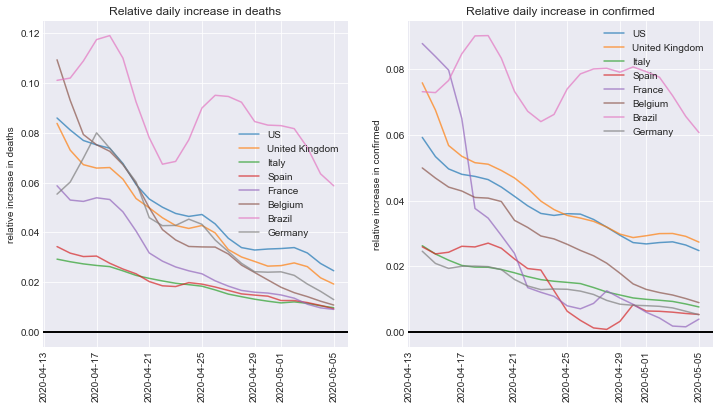

In [85]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-06 2020-05-12  2020-05-06 2020-05-12   
country                                                           
US                  1257038.0  1482461.0     74548.0    89679.0   
United Kingdom       204672.0   243680.0     30883.0    35983.0   
Italy                217165.0   230409.0     29938.0    32152.0   
Spain                219505.0   225662.0     26247.0    28320.0   
France               173089.0   179777.0     26119.0    28295.0   
Brazil               128244.0   196758.0      8985.0    14079.0   
Belgium               52244.0    56789.0      8351.0     9311.0   
Germany              169706.0   177700.0      7371.0     8368.0   
Iran                 101112.0   108232.0      6459.0     6955.0   
Netherlands           42285.0    45413.0      5341.0     5959.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-06 2020-05-12                           
country                                                                 
US                        0.059304   0.060493                0.027872   
United Kingdom            0.150890   0.147665                0.029501   
Italy                     0.137858   0.139543                0.009915   
Spain                     0.119574   0.125497                0.004621   
France                    0.150899   0.157389                0.006338   
Brazil                    0.070062   0.071555                0.073946   
Belgium                   0.159846   0.163958                0.014002   
Germany                   0.043434   0.047091                0.007701   
Iran                      0.063880   0.064260                0.011405   
Netherlands               0.126310   0.131218                0.011966   

               frac_increase_deaths  
date                                 
country                              
US                         0.031278  
United Kingdom             0.025801  
Italy                      0.011957  
Spain                      0.012750  
France                     0.013426  
Brazil                     0.077723  
Belgium                    0.018307  
Germany                    0.021365  
Iran                       0.012409  
Netherlands                0.018407

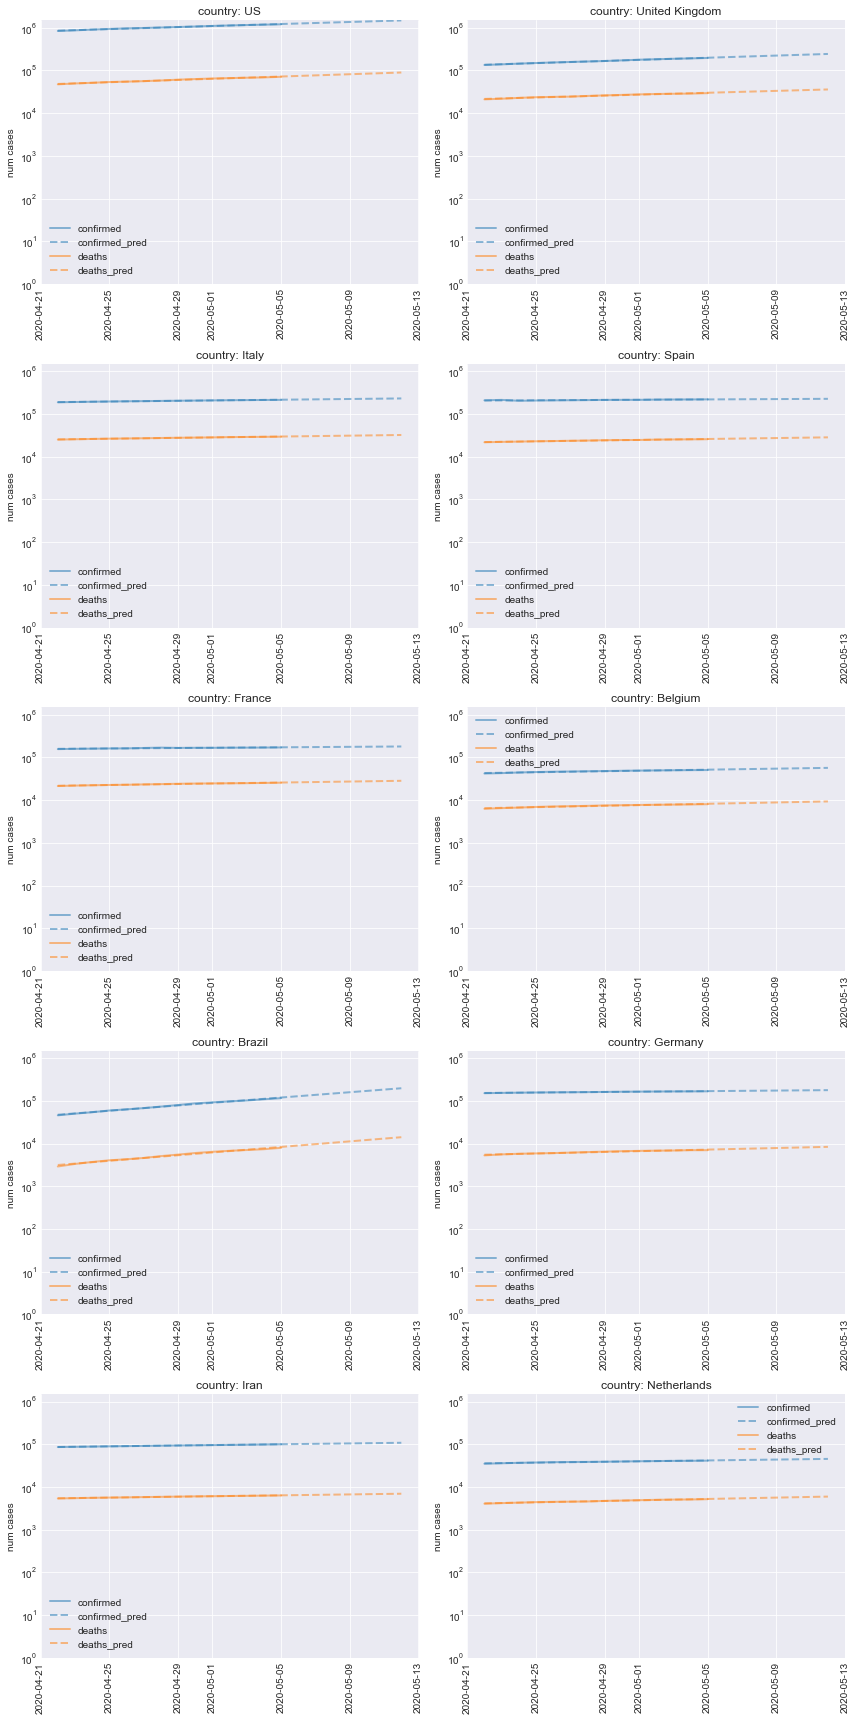

In [86]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [87]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-05_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [88]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

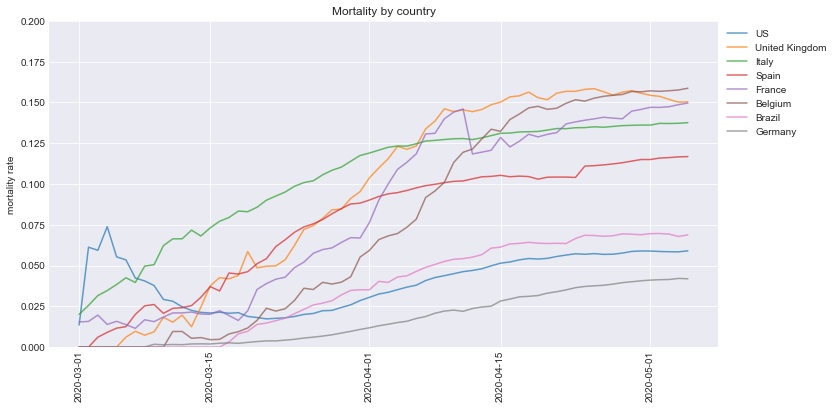

In [89]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [90]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

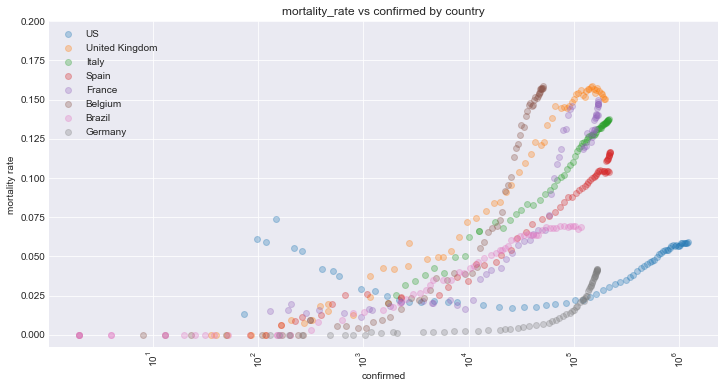

In [91]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [92]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

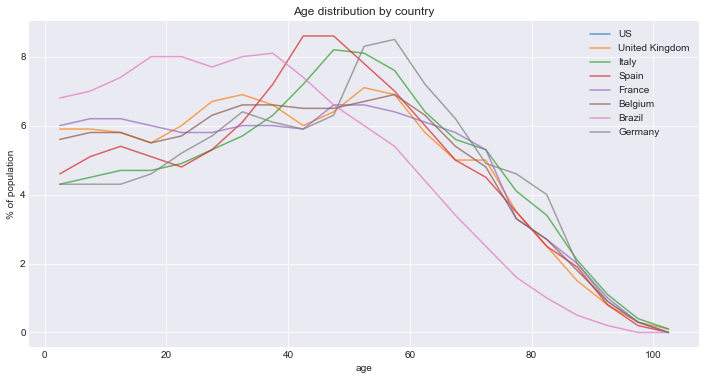

In [93]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

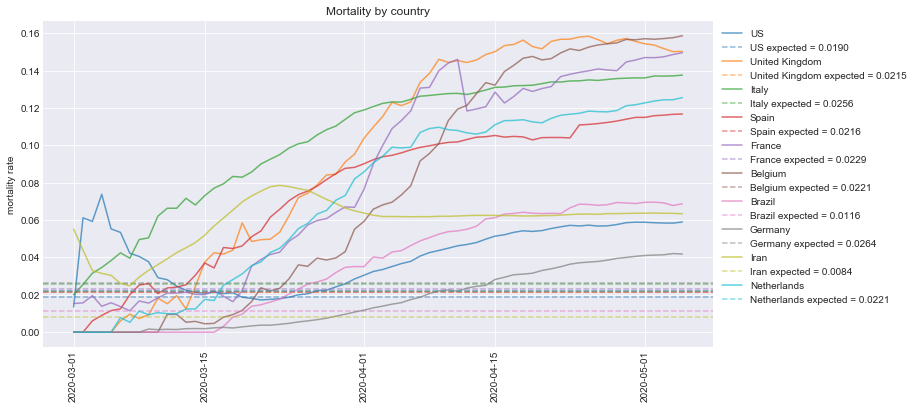

date         country  mortality_rate  confirmed   deaths
0 2020-05-05         Belgium        0.158704    50509.0   8016.0
1 2020-05-05  United Kingdom        0.150329   196243.0  29501.0
2 2020-05-05          France        0.149613   170687.0  25537.0
3 2020-05-05           Italy        0.137621   213013.0  29315.0
4 2020-05-05     Netherlands        0.125587    41286.0   5185.0
5 2020-05-05           Spain        0.116779   219329.0  25613.0
6 2020-05-05          Brazil        0.068754   115455.0   7938.0
7 2020-05-05            Iran        0.063419    99970.0   6340.0
8 2020-05-05              US        0.059006  1204351.0  71064.0
9 2020-05-05         Germany        0.041872   167007.0   6993.0

In [94]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

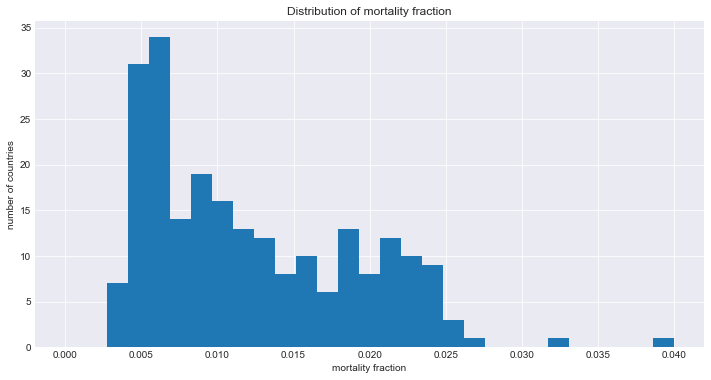

In [95]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [96]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [97]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

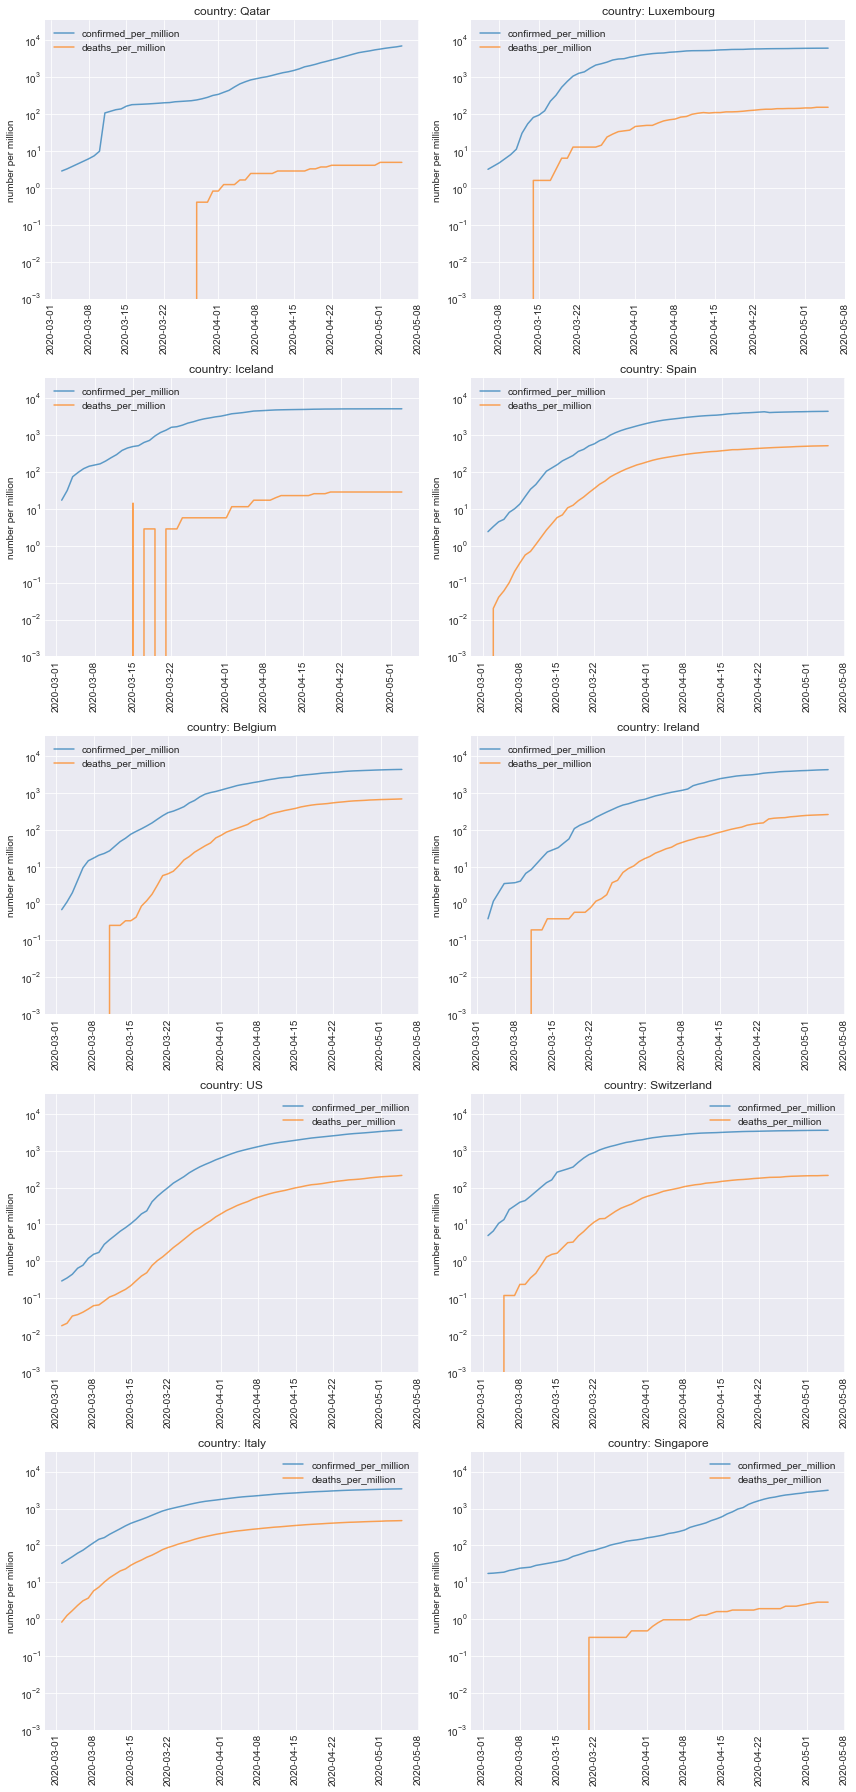

country   population  confirmed   deaths  confirmed_per_million  \
0        Qatar    2444174.0    17142.0     12.0            7013.412302   
1   Luxembourg     628381.0     3840.0     96.0            6110.942247   
2      Iceland     350734.0     1799.0     10.0            5129.243244   
3        Spain   50015792.0   219329.0  25613.0            4385.194980   
4      Belgium   11720716.0    50509.0   8016.0            4309.378369   
5      Ireland    5176569.0    21983.0   1339.0            4246.635175   
6           US  332639102.0  1204351.0  71064.0            3620.593589   
7  Switzerland    8403994.0    30009.0   1795.0            3570.802169   
8        Italy   62402659.0   213013.0  29315.0            3413.524414   
9    Singapore    6209660.0    19410.0     18.0            3125.775002   

   deaths_per_million  mortality_rate  
0            4.909634        0.000700  
1          152.773556        0.025000  
2           28.511636        0.005559  
3          512.098259        0.116779  
4          683.917262        0.158704  
5          258.665537        0.060911  
6          213.636940        0.059006  
7          213.588920        0.059815  
8          469.771649        0.137621  
9            2.898709        0.000927

In [98]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

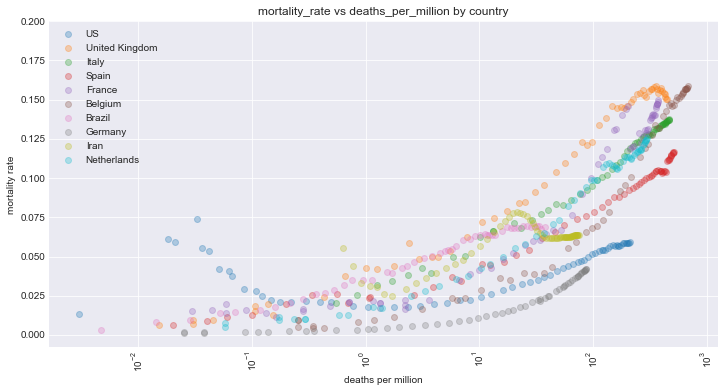

In [99]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

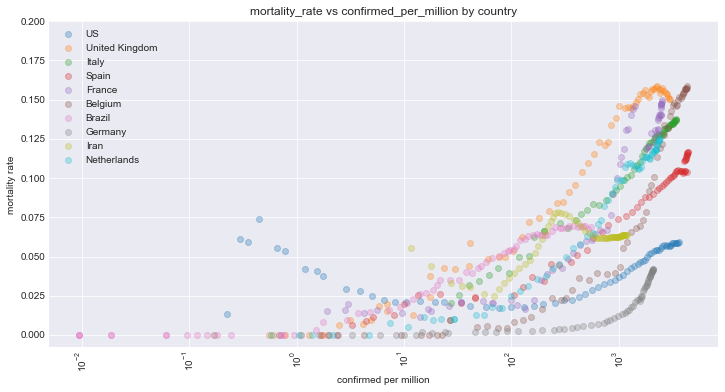

In [100]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [101]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

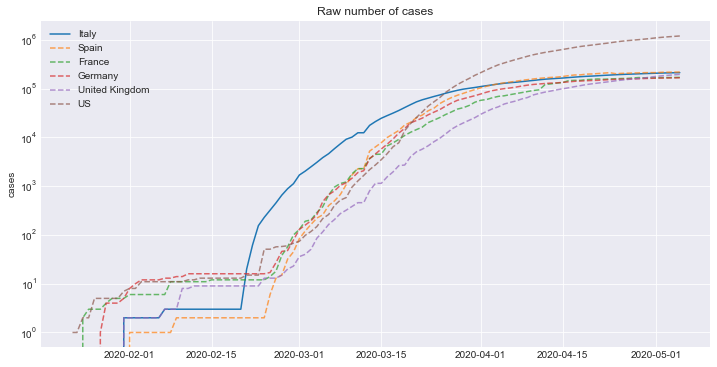

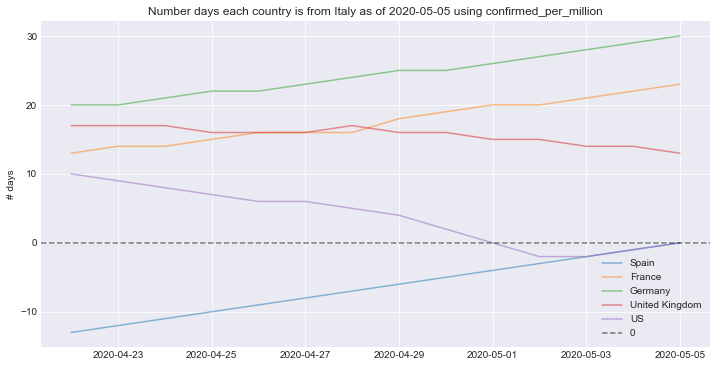

In [102]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

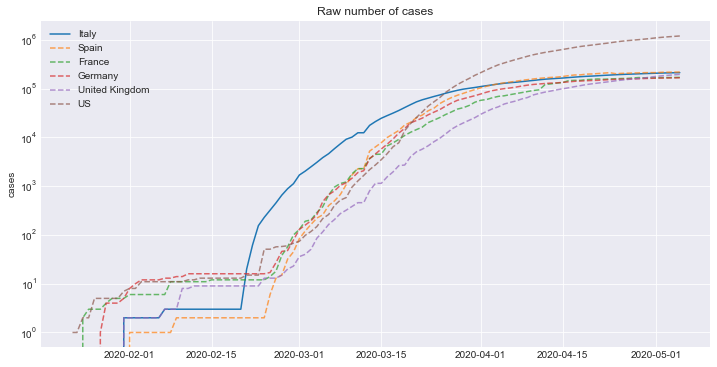

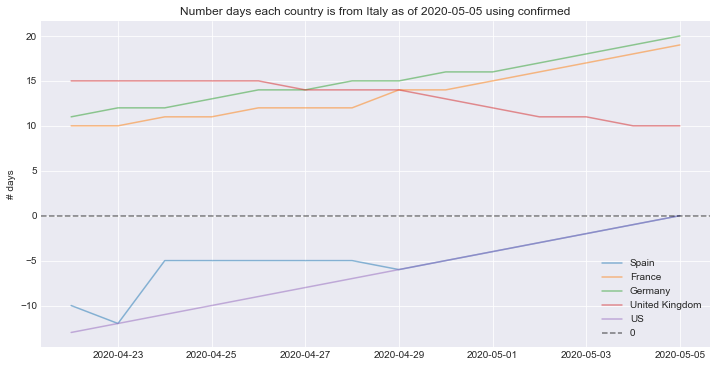

In [103]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [104]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [105]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [106]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [107]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [108]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-06       New York     321192           2239   25124         125   
1  2020-05-06     New Jersey     130593           2324    8244         334   
2  2020-05-06  Massachusetts      70271           1184    4212         122   
3  2020-05-06       Michigan      44451            461    4183          44   
4  2020-05-06   Pennsylvania      53864           1048    3179         341   
5  2020-05-06       Illinois      65889           2112    2834         175   
6  2020-05-06    Connecticut      30621            648    2633          77   
7  2020-05-06     California      58456           2572    2381         103   
8  2020-05-06      Louisiana      29996            323    2115          51   
9  2020-05-06        Florida      37439            542    1471          72   
10 2020-05-06       Maryland      27117            709    1390          73   
11 2020-05-06        Georgia      29998            547    1299          53   
12 2020-05-06        Indiana      21033            526    1211          60   
13 2020-05-06           Ohio      20969            495    1135          78   
14 2020-05-06          Texas      33912           1129     925          24   

    mortality_rate  
0         0.078221  
1         0.063127  
2         0.059939  
3         0.094104  
4         0.059019  
5         0.043012  
6         0.085987  
7         0.040731  
8         0.070509  
9         0.039291  
10        0.051259  
11        0.043303  
12        0.057576  
13        0.054128  
14        0.027276

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [109]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

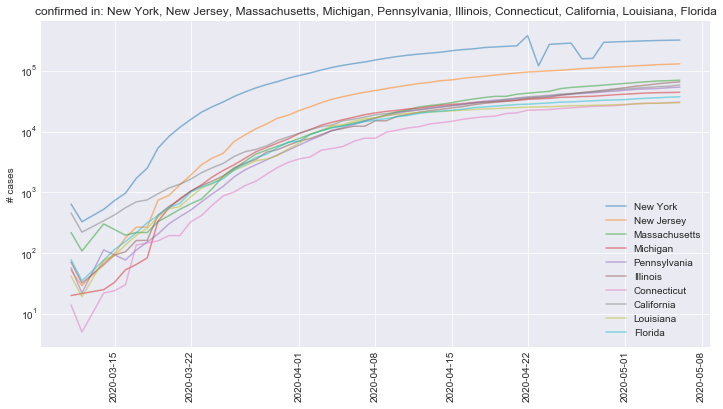

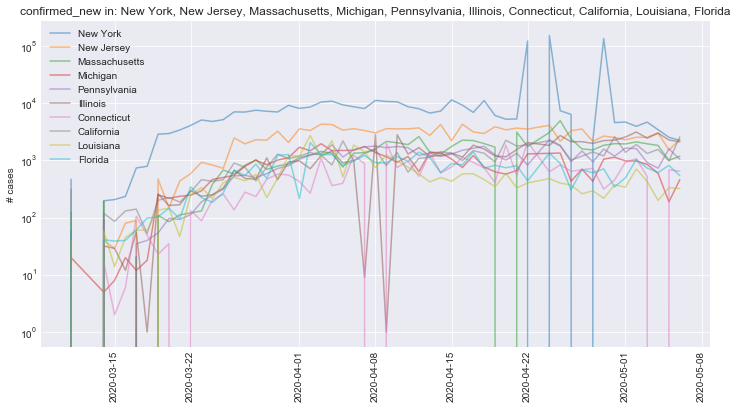

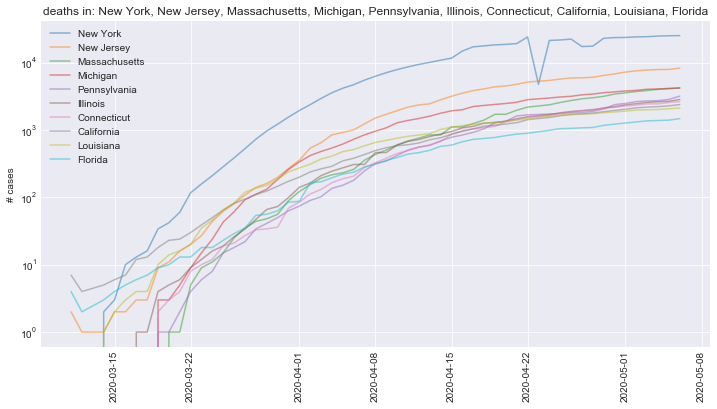

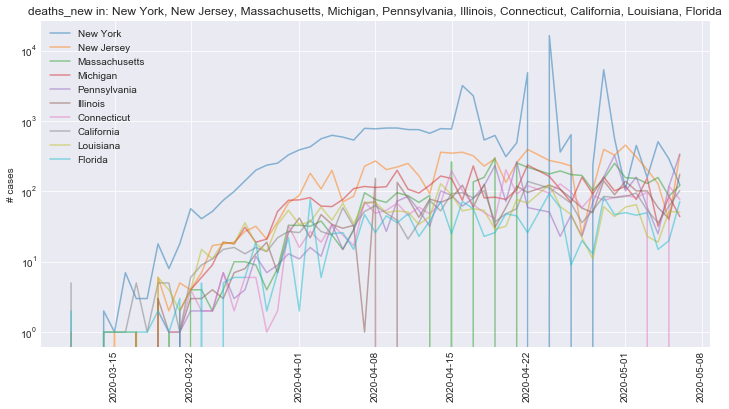

In [110]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

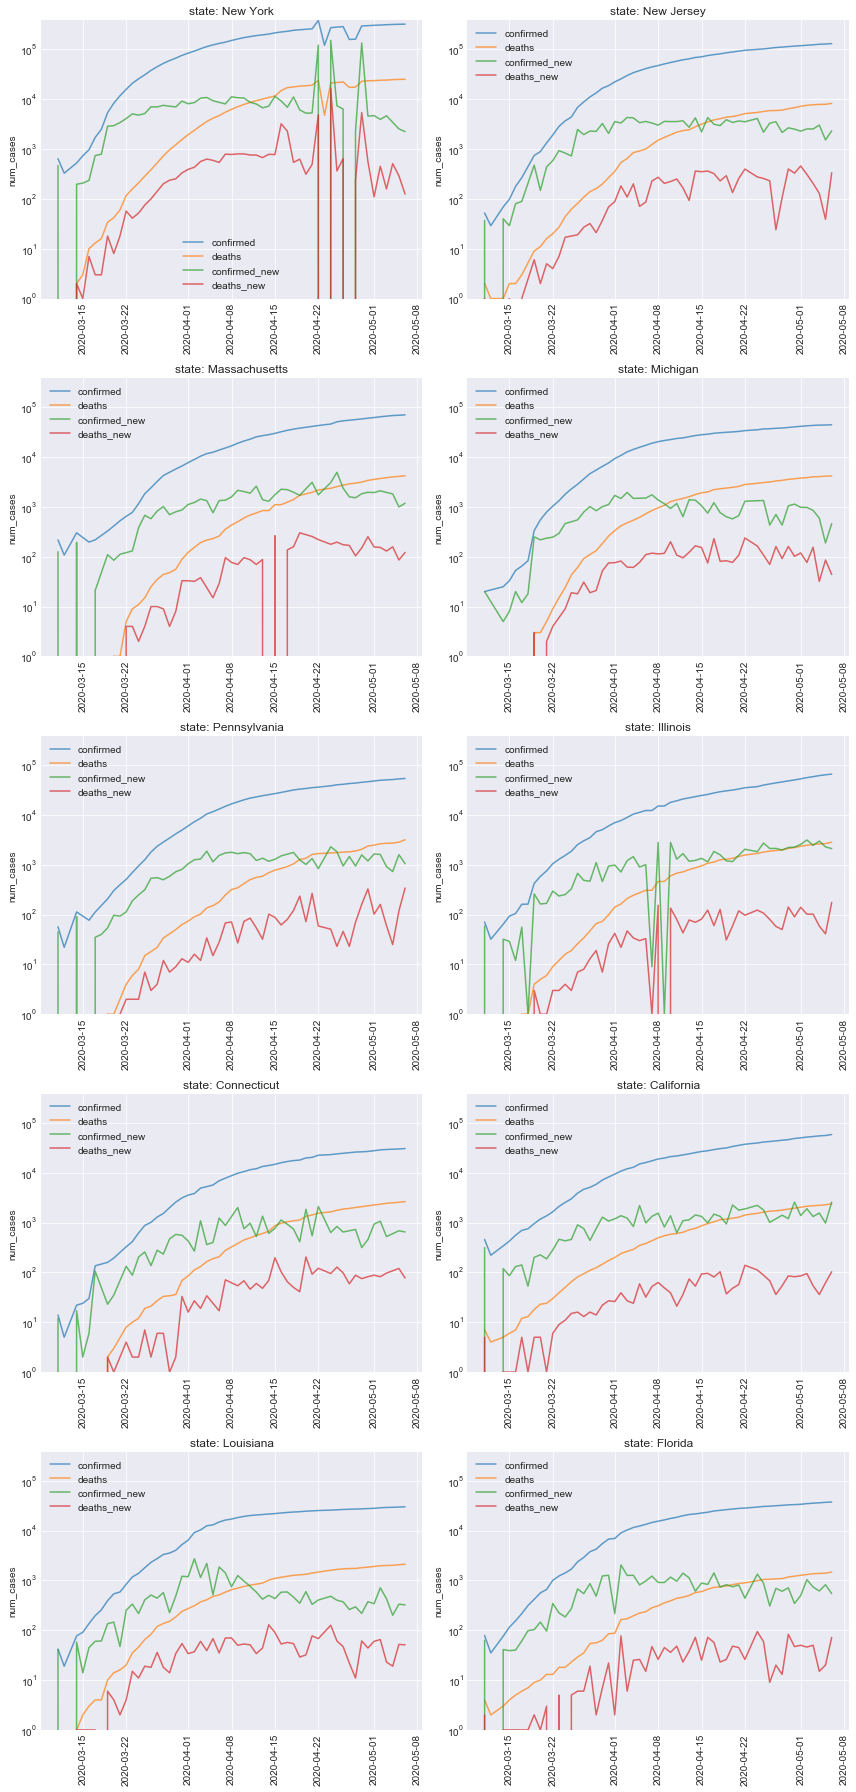

In [111]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

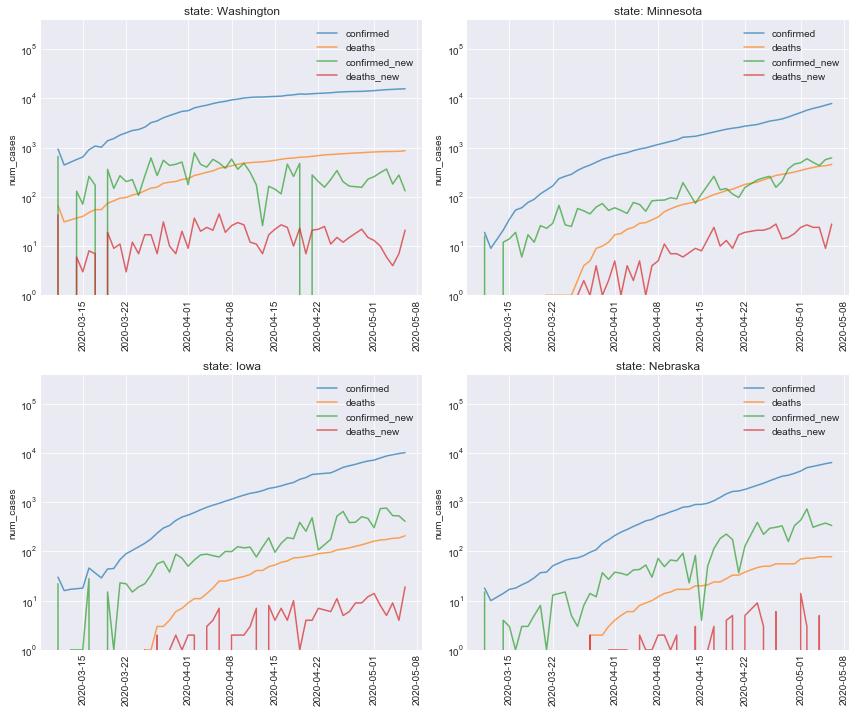

In [112]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-07 2020-05-13 2020-05-27  2020-05-07 2020-05-13   
state                                                                       
New York            326535.0   350265.0   412561.0     25532.0    27503.0   
New Jersey          133589.0   150194.0   197413.0      8538.0    10165.0   
Massachusetts        72891.0    85192.0   122582.0      4404.0     5444.0   
Michigan             45567.0    50101.0    62513.0      4320.0     4930.0   
Pennsylvania         55372.0    64021.0    89825.0      3187.0     4106.0   
Illinois             69787.0    91662.0   173179.0      2927.0     3662.0   
Connecticut          31380.0    35527.0    47463.0      2716.0     3274.0   
California           59850.0    71287.0   107204.0      2449.0     2955.0   
Louisiana            30537.0    33134.0    40086.0      2159.0     2450.0   
Florida              38382.0    43472.0    58130.0      1507.0     1793.0   

                         mortality_rate_pred                        \
date          2020-05-27          2020-05-07 2020-05-13 2020-05-27   
state                                                                
New York         32717.0            0.078191   0.078521   0.079302   
New Jersey       15272.0            0.063912   0.067679   0.077361   
Massachusetts     8927.0            0.060419   0.063903   0.072825   
Michigan          6710.0            0.094805   0.098401   0.107338   
Pennsylvania      7417.0            0.057556   0.064135   0.082572   
Illinois          6177.0            0.041942   0.039951   0.035668   
Connecticut       5061.0            0.086552   0.092155   0.106630   
California        4579.0            0.040919   0.041452   0.042713   
Louisiana         3293.0            0.070701   0.073942   0.082148   
Florida           2690.0            0.039263   0.041245   0.046276   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.011761             0.012475  
New Jersey                   0.019718             0.029501  
Massachusetts                0.026331             0.035959  
Michigan                     0.015935             0.022260  
Pennsylvania                 0.024484             0.043144  
Illinois                     0.046492             0.038049  
Connecticut                  0.020905             0.031597  
California                   0.029573             0.031789  
Louisiana                    0.013696             0.021337  
Florida                      0.020971             0.029392

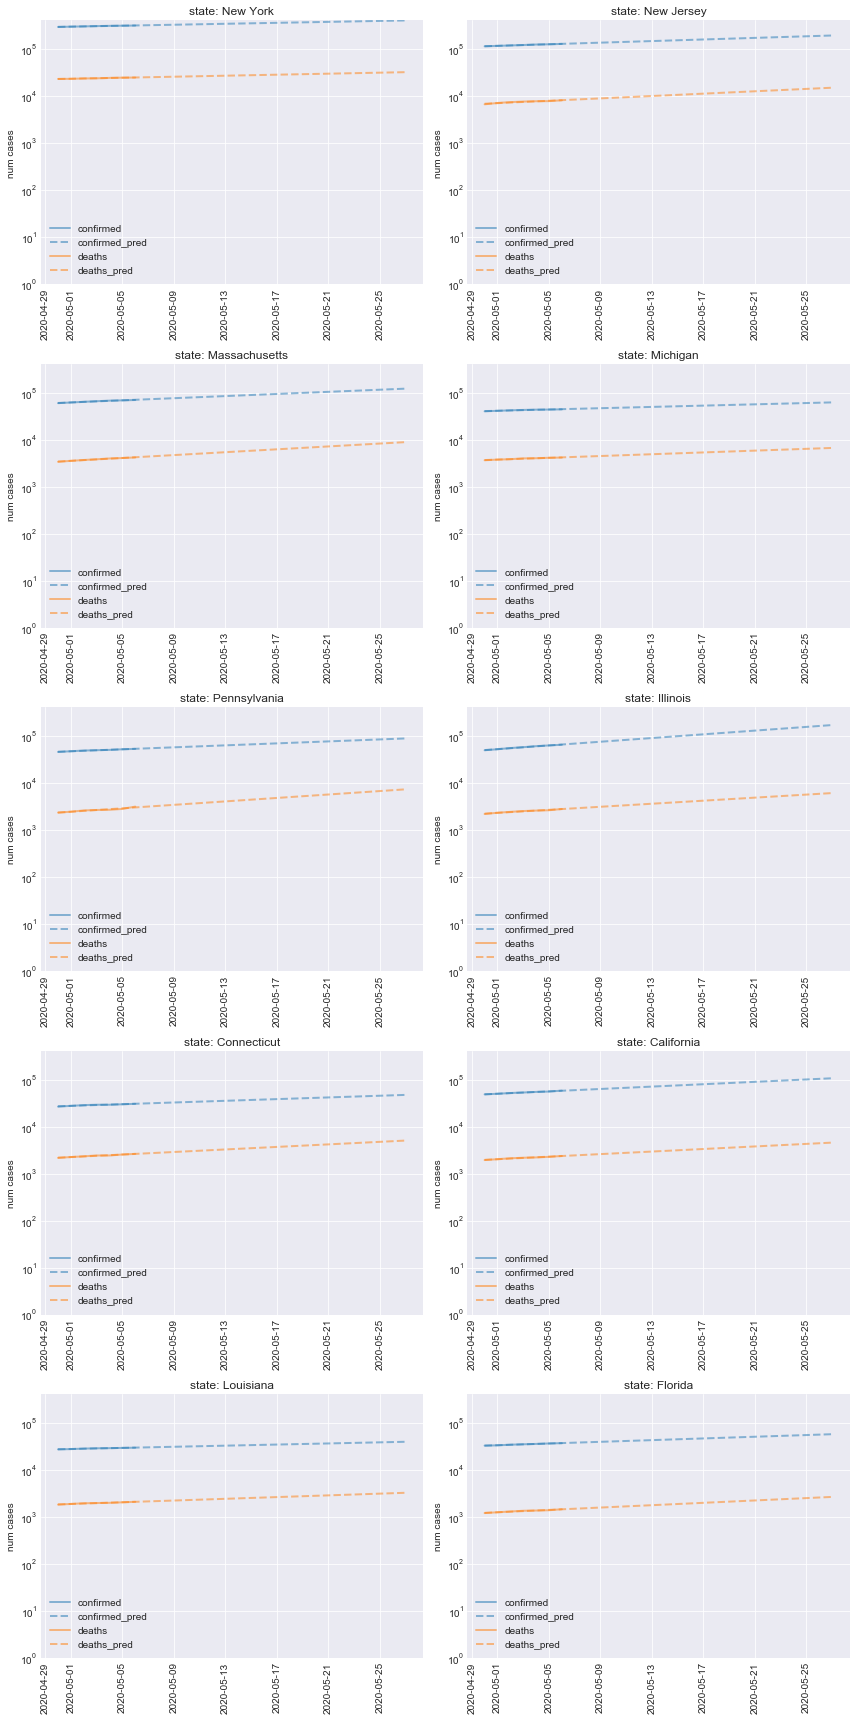

In [113]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-07 2020-05-13 2020-05-27  2020-05-07 2020-05-13   
state                                                                       
New York            366446.0   485746.0   937576.0     31664.0    45644.0   
New Jersey          135085.0   154444.0   211101.0      8736.0    10880.0   
Massachusetts        74838.0    90976.0   143486.0      4614.0     6158.0   
Michigan             46196.0    52061.0    68810.0      4444.0     5311.0   
Pennsylvania         56161.0    66448.0    98384.0      3286.0     4541.0   
Illinois             70511.0    94094.0   184478.0      2980.0     3852.0   
Connecticut          31682.0    36402.0    50333.0      2786.0     3492.0   
California           60428.0    73323.0   115144.0      2490.0     3092.0   
Louisiana            30453.0    32913.0    39451.0      2170.0     2489.0   
Florida              38195.0    42877.0    56154.0      1527.0     1867.0   

                         mortality_rate_pred                        \
date          2020-05-27          2020-05-07 2020-05-13 2020-05-27   
state                                                                
New York        107139.0            0.086408   0.093967   0.114272   
New Jersey       18160.0            0.064670   0.070446   0.086025   
Massachusetts    12075.0            0.061653   0.067688   0.084155   
Michigan          8048.0            0.096199   0.102015   0.116960   
Pennsylvania      9656.0            0.058510   0.068339   0.098146   
Illinois          7009.0            0.042263   0.040938   0.037994   
Connecticut       5913.0            0.087936   0.095929   0.117478   
California        5127.0            0.041206   0.042170   0.044527   
Louisiana         3427.0            0.071257   0.075624   0.086867   
Florida           2982.0            0.039979   0.043543   0.053104   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.048093             0.062843  
New Jersey                   0.022573             0.037266  
Massachusetts                0.033081             0.049275  
Michigan                     0.020123             0.030138  
Pennsylvania                 0.028429             0.055368  
Illinois                     0.049263             0.043685  
Connecticut                  0.023415             0.038330  
California                   0.032761             0.036780  
Louisiana                    0.013026             0.023095  
Florida                      0.019456             0.034032

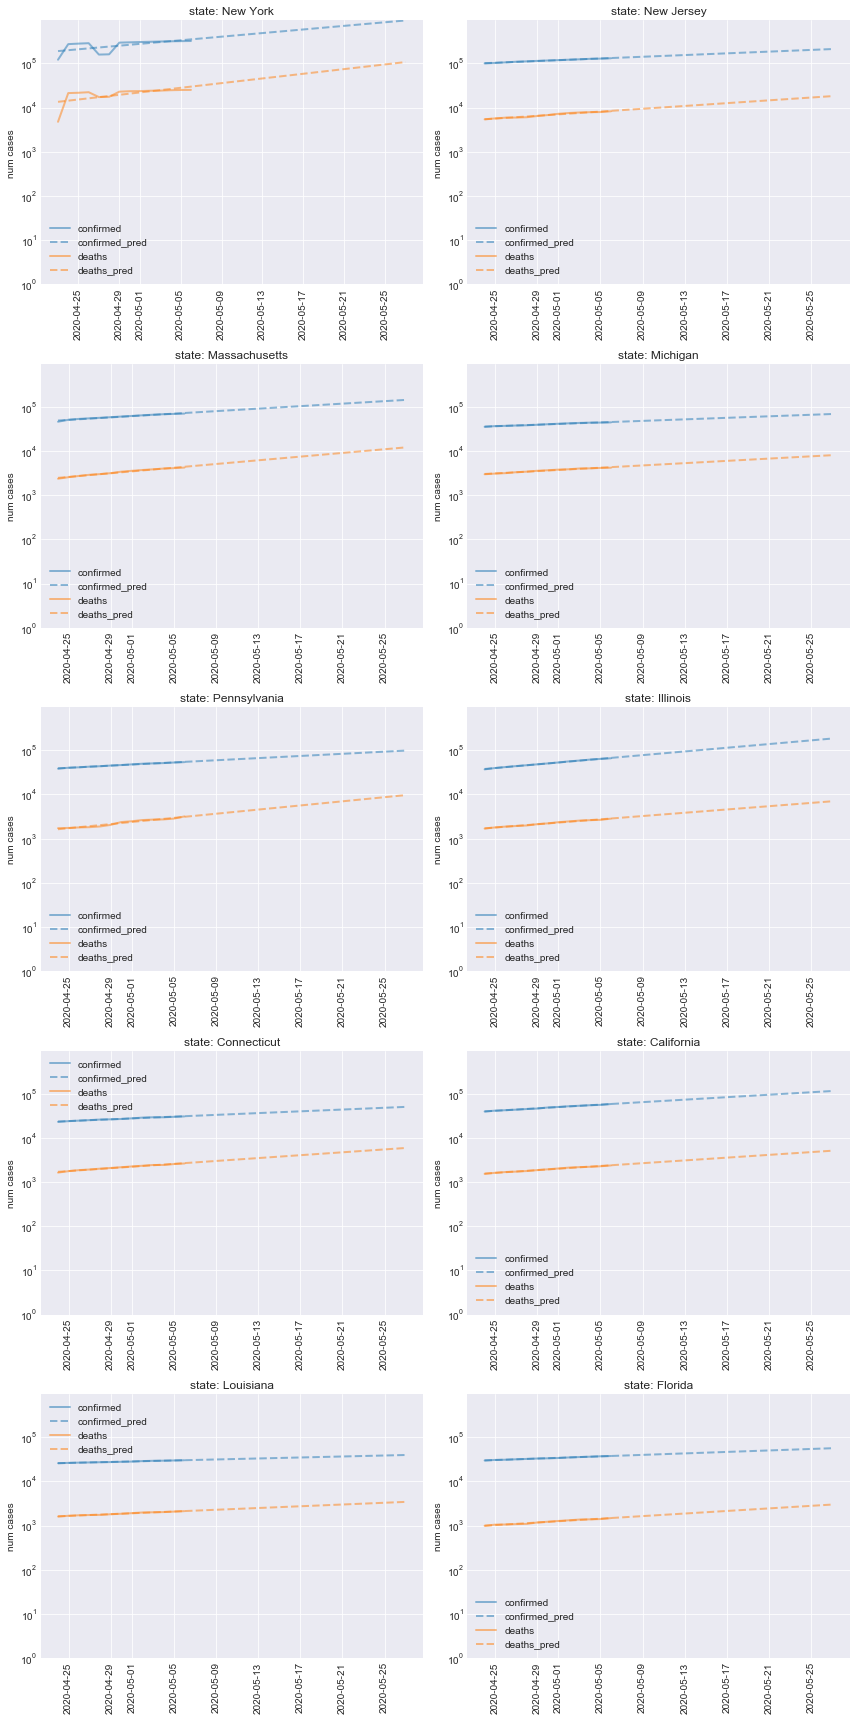

In [114]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [115]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [116]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-05-06          South Dakota       2721      24           3   
1  2020-05-06              Arkansas       3525      83           3   
2  2020-05-06            New Mexico       4138     162           6   
3  2020-05-06         New Hampshire       2636      92           6   
4  2020-05-06          Rhode Island       9933     355          14   
5  2020-05-06             Minnesota       7851     455          28   
6  2020-05-06              Virginia      20257     713          29   
7  2020-05-06          North Dakota       1266      25           0   
8  2020-05-06                  Iowa      10111     207          19   
9  2020-05-06           Mississippi       8207     342          32   
10 2020-05-06              Nebraska       6373      78           0   
11 2020-05-06              Delaware       5371     187           5   
12 2020-05-06              Maryland      27117    1390          73   
13 2020-05-06          Pennsylvania      53864    3179         341   
14 2020-05-06        South Carolina       6841     296          13   
15 2020-05-06  District of Columbia       5322     264           6   
16 2020-05-06               Arizona       9305     395          33   
17 2020-05-06         West Virginia       1246      48           0   
18 2020-05-06              Illinois      65889    2834         175   
19 2020-05-06         Massachusetts      70271    4212         122   
20 2020-05-06                  Utah       5449      56           6   
21 2020-05-06            California      58456    2381         103   
22 2020-05-06           Connecticut      30621    2633          77   
23 2020-05-06                Kansas       5648     161           5   
24 2020-05-06                 Texas      33912     925          24   
25 2020-05-06              Missouri       9121     409          23   
26 2020-05-06            New Jersey     130593    8244         334   
27 2020-05-06        North Carolina      12510     472          30   
28 2020-05-06               Florida      37439    1471          72   
29 2020-05-06               Alabama       8437     315          17   
30 2020-05-06                  Ohio      20969    1135          78   
31 2020-05-06               Indiana      21033    1211          60   
32 2020-05-06               Georgia      29998    1299          53   
33 2020-05-06              Kentucky       5822     275          14   
34 2020-05-06                Nevada       5660     270           5   
35 2020-05-06              Colorado      17367     903          52   
36 2020-05-06             Tennessee      13690     226           7   
37 2020-05-06                 Maine       1226      61           4   
38 2020-05-06              Oklahoma       4127     247           9   
39 2020-05-06              Michigan      44451    4183          44   
40 2020-05-06             Wisconsin       8566     353          13   
41 2020-05-06             Louisiana      29996    2115          51   
42 2020-05-06           Puerto Rico       1924      99           2   
43 2020-05-06                Oregon       2839     113           4   
44 2020-05-06               Vermont        907      52           0   
45 2020-05-06                 Idaho       2127      65           1   
46 2020-05-06                Hawaii        625      17           0   
47 2020-05-06              New York     321192   25124         125   
48 2020-05-06            Washington      15594     862          21   
49 2020-05-06        Grand Princess        103       3           0   
50 2020-05-06        Virgin Islands         66       4           0   
51 2020-05-06               Montana        456      16           0   
52 2020-05-06                  Guam        145       5           0   
53 2020-05-06                Alaska        371       9           0   
54 2020-05-06               Wyoming        604       7           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.022         

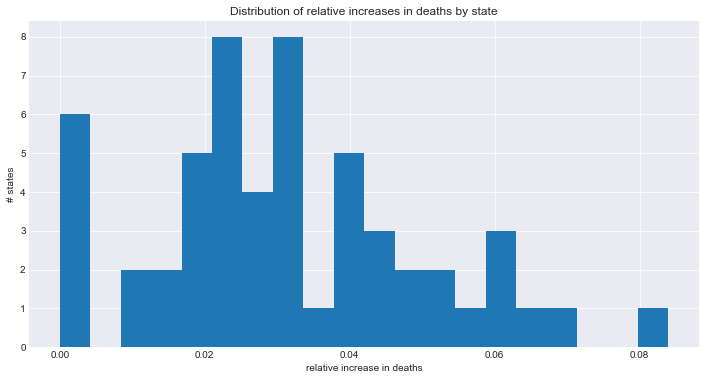

In [117]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

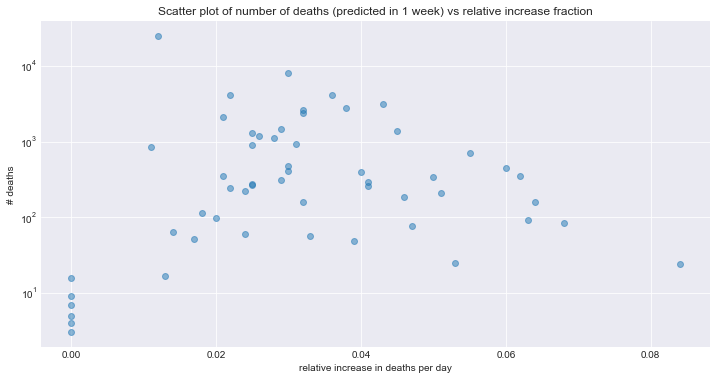

In [118]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [119]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

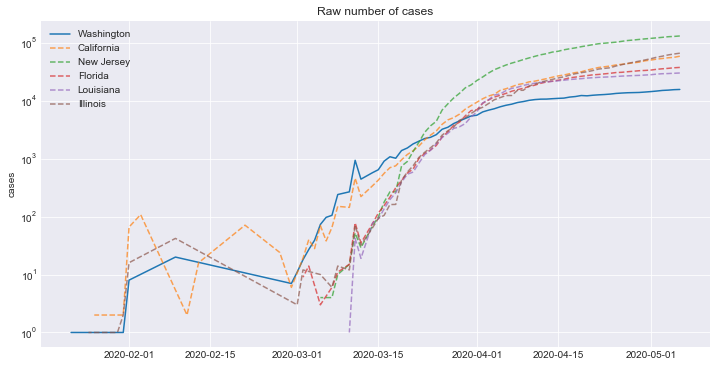

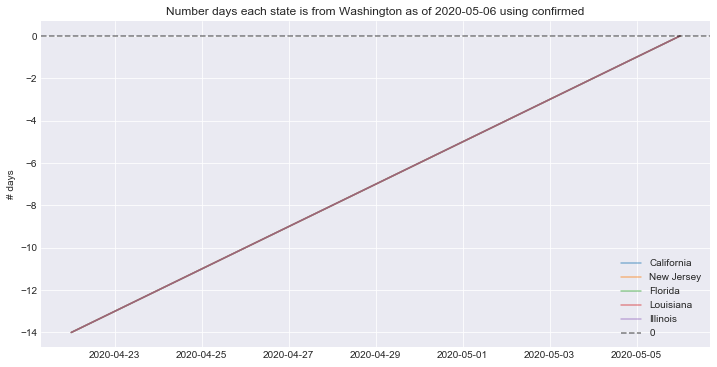

In [120]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

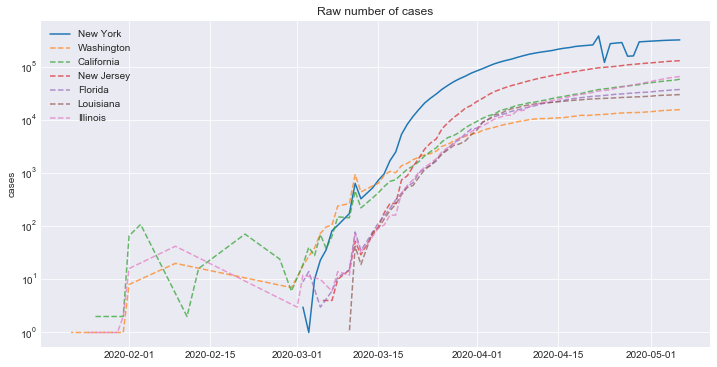

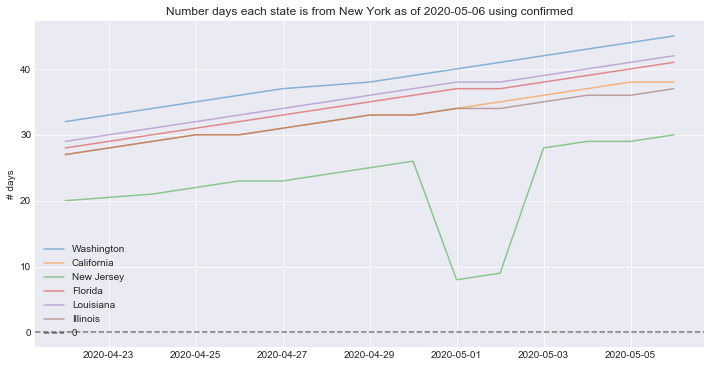

In [121]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

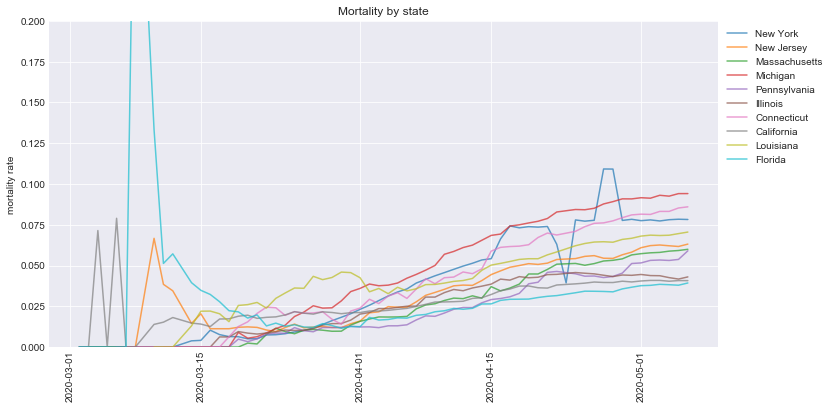

In [122]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

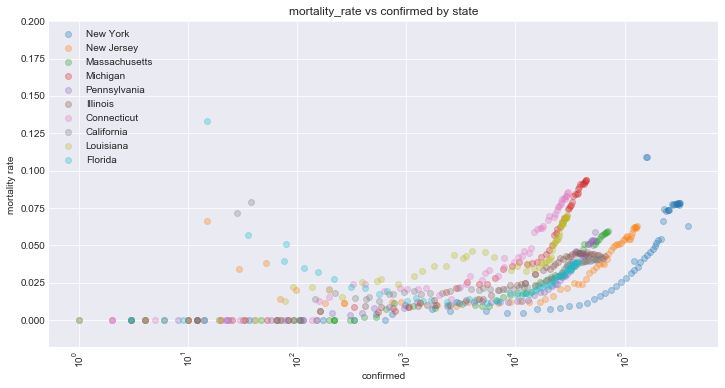

In [123]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

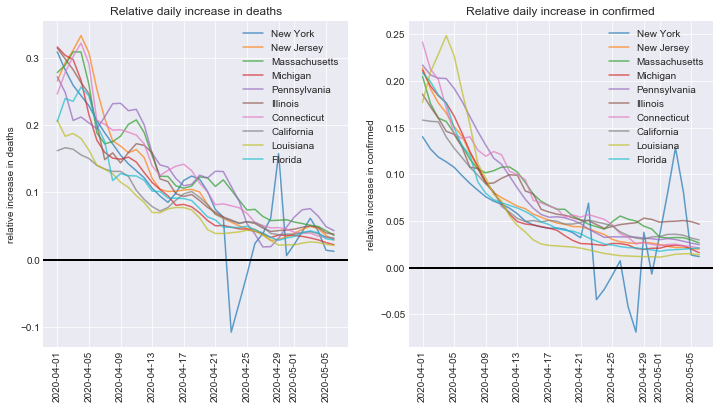

In [124]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [125]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={'deaths_new'})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest['deaths_new_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [126]:
n_days_training = 28
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-07 2020-05-13 2020-05-20 2020-06-03 2020-07-01   
state                                                                          
New York                    5246       4345       3488       2247        932   
Illinois                    2601       2982       3497       4810       9101   
New Jersey                  2294       2056       1810       1402        841   
California                  1809       2022       2301       2982       5005   
Massachusetts               1757       1683       1601       1449       1186   
Pennsylvania                1152       1086       1013        882        669   
Connecticut                  603        541        477        371        224   
Michigan                     570        492        414        293        146   
Florida                      550        481        411        301        161   
Louisiana                    266        217        171        105         40   

                                                                      \
date          2020-07-29 2020-08-26 2020-09-23 2020-10-21 2020-12-16   
state                                                                  
New York             387        160         66         27          4   
Illinois           17216      32569      61613     116556     417115   
New Jersey           504        303        181        109         39   
California          8400      14098      23663      39715     111877   
Massachusetts        971        795        651        533        358   
Pennsylvania         507        384        291        221        127   
Connecticut          135         82         49         30         10   
Michigan              73         36         18          9          2   
Florida               86         46         24         13          3   
Louisiana             15          5          2          0          0   

              deaths_new_pred                                              \
date               2020-05-07 2020-05-13 2020-05-20 2020-06-03 2020-07-01   
state                                                                       
New York                  356        269        194        101         27   
Illinois                   91         94         98        107        126   
New Jersey                176        163        150        125         88   
California                 79         87         97        121        186   
Massachusetts             172        184        200        235        324   
Pennsylvania              108        123        143        194        355   
Connecticut               100        109        121        148        221   
Michigan                   79         69         59         44         24   
Florida                    33         32         30         27         22   
Louisiana                  36         33         29         23         14   

                                                                      \
date          2020-07-29 2020-08-26 2020-09-23 2020-10-21 2020-12-16   
state                                                                  
New York               7          2          0          0          0   
Illinois             148        175        207        244        340   
New Jersey            62         43         30         21         10   
California           288        444        684       1056       2510   
Massachusetts        447        616        850       1173       2230   
Pennsylvania         651       1194       2187       4006      13442   
Connecticut          331        495        740       1107       2477   
Michigan              13          7          3          2          0   
Florida               18         15         12         10          7   
Louisiana              8          5          3          1          0   

              frac_increase_confirmed frac_increase_deaths  
date                                

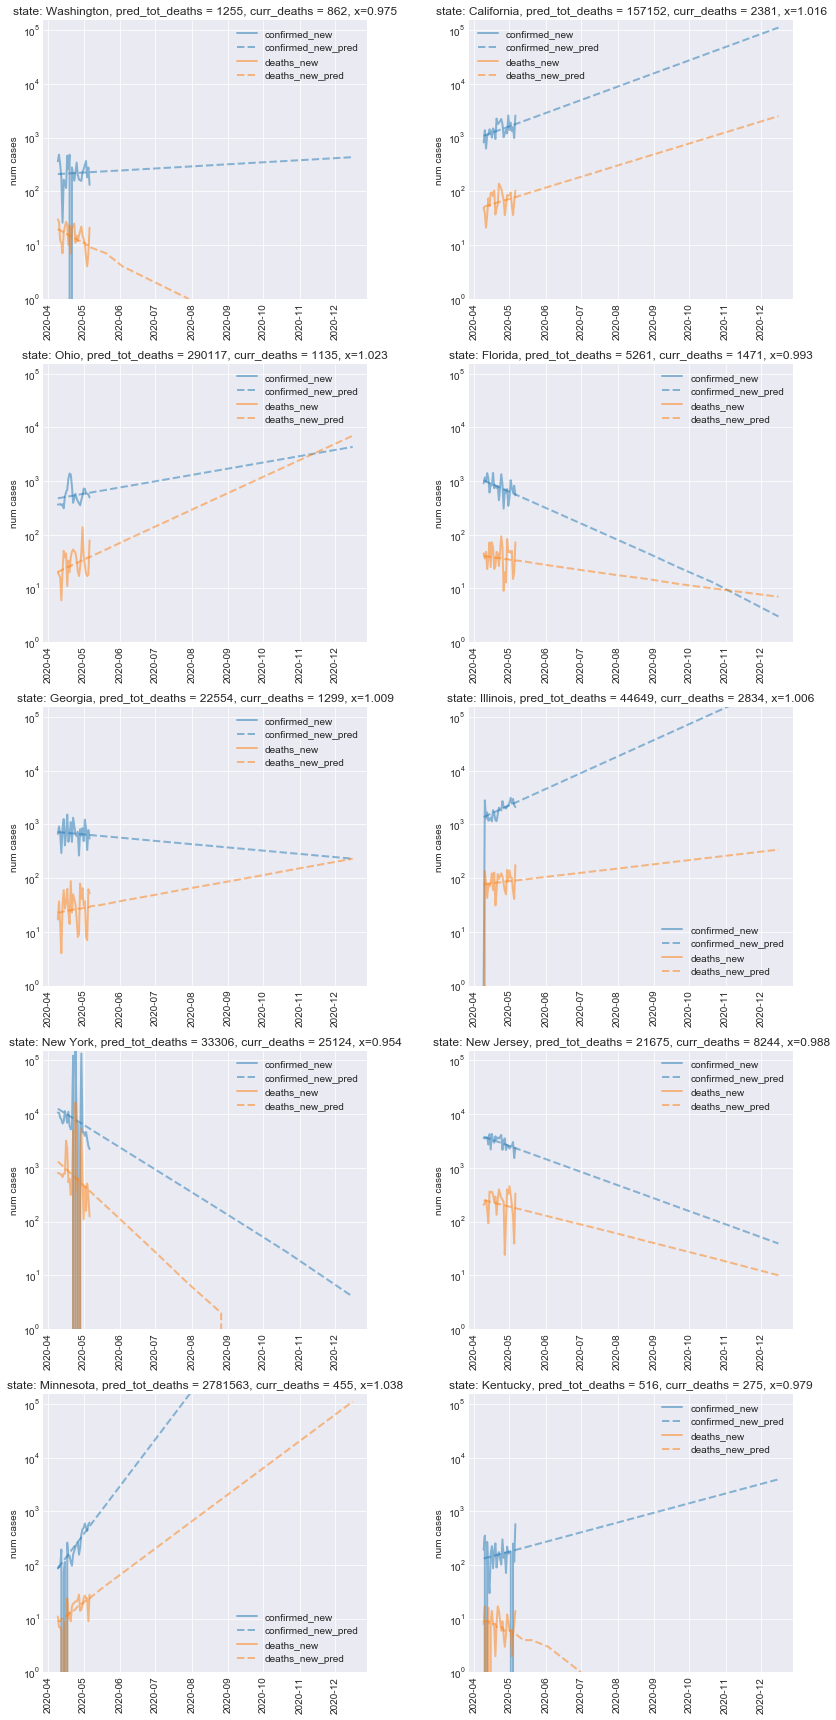

In [127]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky'])

In [128]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-06_n_days_training=28.csv


### Which states are increasing in new deaths <u>most</u> quickly?

In [129]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0              Maryland              0.042735                 0.017880
1             Minnesota              0.038191                 0.068830
2                  Iowa              0.037995                 0.071692
3              Virginia              0.033005                 0.034894
4               Arizona              0.026576                 0.029277
5  District of Columbia              0.026264                 0.017379
6        South Carolina              0.024955                -0.006267
7           Mississippi              0.024040                 0.011890
8                  Ohio              0.023433                 0.008813
9            New Mexico              0.023324                 0.029748

### Which states are increasing in new deaths <u>least</u> quickly?

In [130]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48   New Jersey             -0.012452                -0.018072
49       Kansas             -0.012736                 0.055822
50    Wisconsin             -0.013252                 0.037842
51  Puerto Rico             -0.014696                 0.009867
52     Colorado             -0.015929                 0.019090
53    Louisiana             -0.017316                -0.033639
54     Kentucky             -0.020566                 0.013618
55     Michigan             -0.021369                -0.024370
56   Washington             -0.025341                 0.002887
57     New York             -0.045586                -0.030916

### Is there a day-of-the-week effect on new deaths?

In [131]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [132]:
dfp_us_dow['death_delta'] = dfp_us_dow['deaths_new']- dfp_us_dow['deaths_new_pred']
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow['deaths_new_pred']

dfp_us_dow['confirmed_delta'] = dfp_us_dow['confirmed_new']- dfp_us_dow['confirmed_new_pred']
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow['confirmed_new_pred']
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.median, 
                          'deaths_new': np.mean, 
                          'deaths_new_pred': np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.median})
                    )

In [133]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -5.500000        -0.566667        8.25   
379  Washington    1     1.333333         0.000000       15.00   
380  Washington    2     8.500000         0.702381       21.75   
381  Washington    3     9.000000         0.593750       24.25   
382  Washington    4     4.000000         0.301435       18.75   
383  Washington    5    -2.750000        -0.212121       11.75   
384  Washington    6    -0.750000        -0.194444       13.00   

     deaths_new_pred  confirmed_delta  confirmed_rel_delta  
378        13.750000      -160.250000            -0.563679  
379        13.666667        21.333333             0.225664  
380        13.250000       -60.750000            -0.312968  
381        15.250000         0.000000            -0.126395  
382        14.750000       138.750000             0.651000  
383        14.500000        89.500000             0.441964  
384        13.750000        88.000000             0.276055

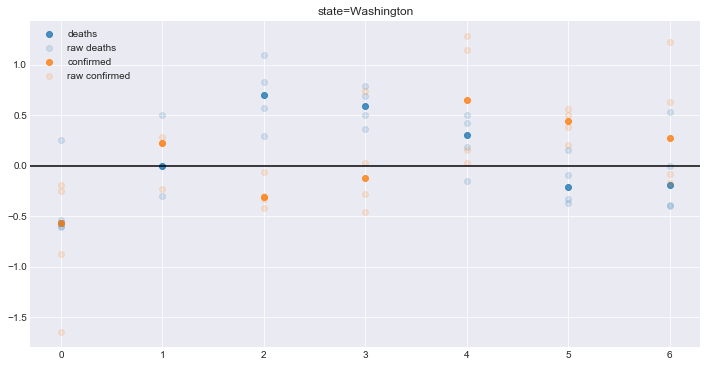

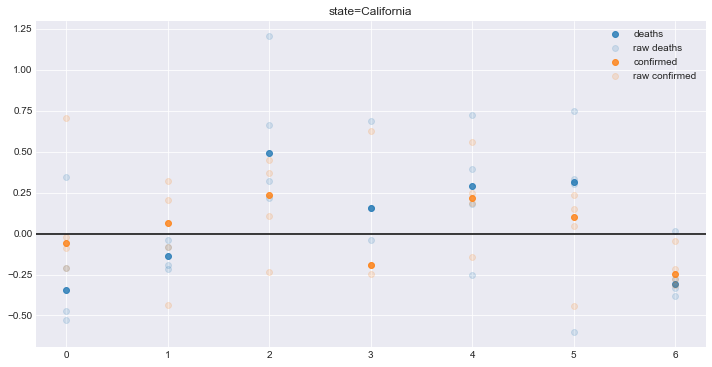

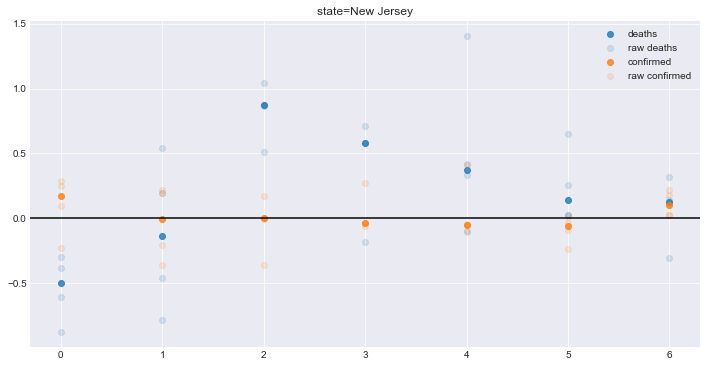

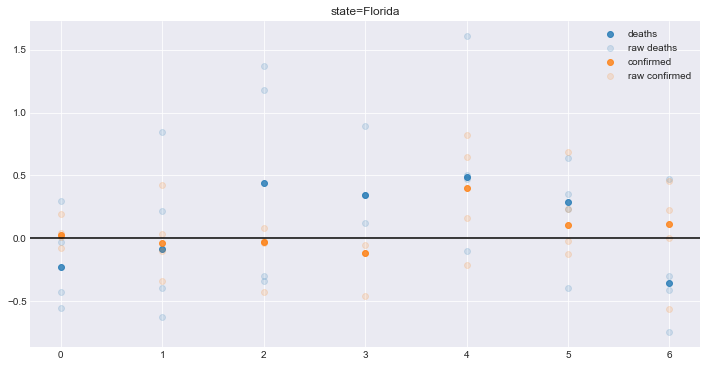

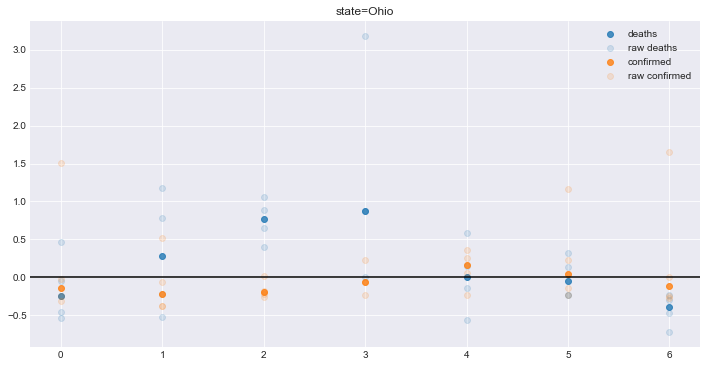

In [134]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()